In [17]:
from sklearn.preprocessing import MinMaxScaler
from joblib import dump
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [18]:
def split_dataframe(df: pl.DataFrame, train_ratio: float = 0.7, val_ratio: float = 0.15, test_ratio: float = 0.15):
    total_rows = df.height
    train_end = int(total_rows * train_ratio)
    val_end = train_end + int(total_rows * val_ratio)

    return (
        df
            .with_columns(
                pl.when(
                    pl.arange(0, df.height) < train_end
                )
                .then(pl.lit('train'))
                .when(
                    pl.arange(0, df.height) < val_end
                )
                .then(pl.lit('val'))
                .otherwise(pl.lit('test'))
                .alias('split_type')
            )
    )

In [19]:
def normalization(scaler_class, df: pl.DataFrame):
    scaler_name = str(scaler_class).split(".")[-1].replace("'>", "")

    train_close = (
        df.filter(pl.col("split_type") == "train")["Global_active_power"]
        .to_numpy()
        .reshape(-1, 1)
    )

    scaler = scaler_class()

    scaler.fit(train_close)

    return df.with_columns(
        pl.Series(
            f"Global_active_power_{scaler_name}",
            scaler.transform(
                df["Global_active_power"].to_numpy().reshape(-1, 1)
            ).flatten(),
        )
    )

In [20]:
data = pd.read_csv(
    "../data/raw/household_power_consumption.txt",
    sep=";",
    parse_dates={"dt": ["Date", "Time"]},
    infer_datetime_format=True,
    low_memory=False,
    na_values=["nan", "?"],
    index_col="dt",
)

data.tail()

/tmp/ipykernel_1748029/1446973747.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(
/tmp/ipykernel_1748029/1446973747.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(
/tmp/ipykernel_1748029/1446973747.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


In [21]:
data = data.fillna(data.mean())

In [22]:
data = data.resample('h').mean()

In [23]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000


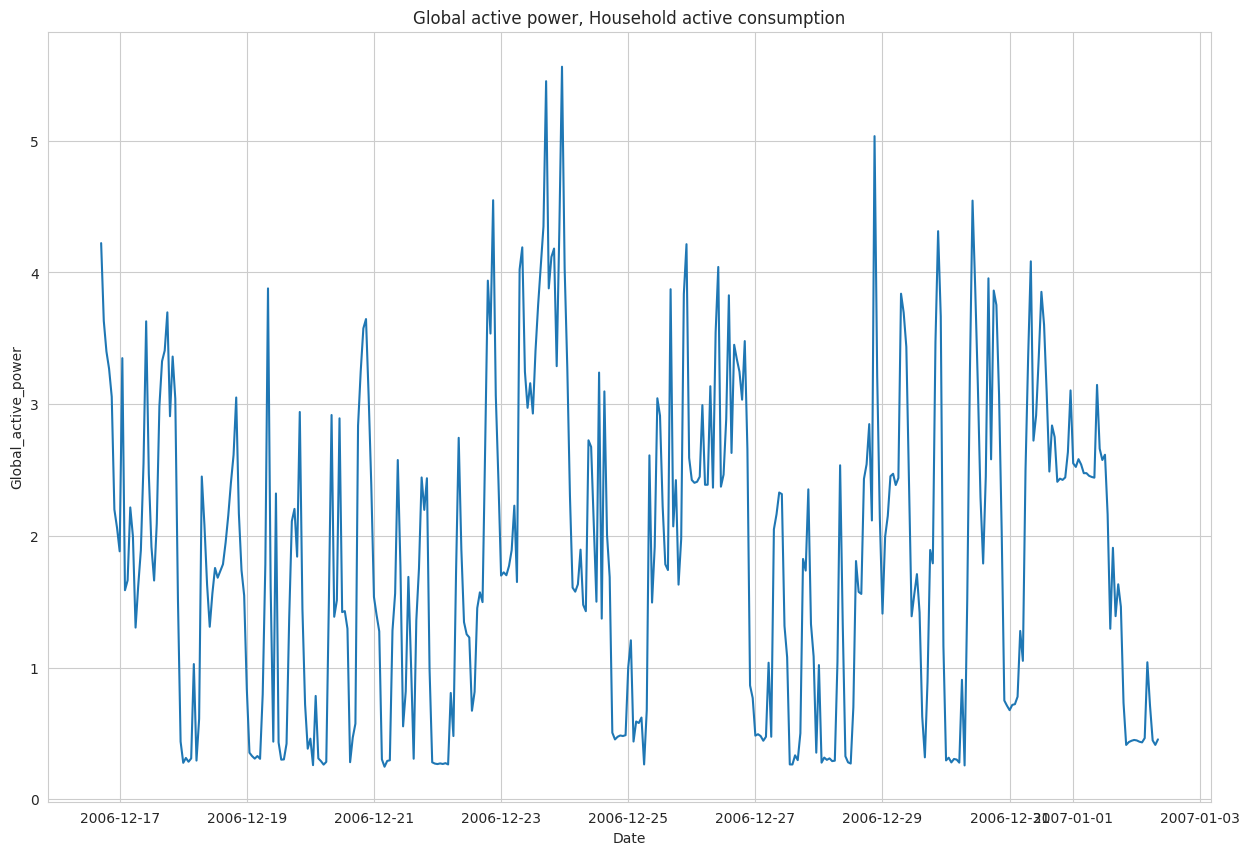

In [16]:
plt.figure(figsize=(15, 10))

sns.lineplot(data["Global_active_power"][:400])

plt.title('Global active power, Household active consumption')

plt.xlabel('Date')
plt.show()

In [24]:
data = pl.DataFrame({"Global_active_power": data.sort_index()["Global_active_power"], 'date': data.index})

In [26]:
data = split_dataframe(data)

In [27]:
data = normalization(MinMaxScaler, data)

In [28]:
data.write_csv("../data/processed/global_active_power.csv")

In [29]:
pl.read_csv('../data/processed/global_active_power.csv')

Global_active_power,date,split_type,Global_active_power_MinMaxScaler
f64,str,str,f64
4.222889,"""2006-12-16T17:00:00.000000000""","""train""",0.636816
3.6322,"""2006-12-16T18:00:00.000000000""","""train""",0.545045
3.400233,"""2006-12-16T19:00:00.000000000""","""train""",0.509006
3.268567,"""2006-12-16T20:00:00.000000000""","""train""",0.48855
3.056467,"""2006-12-16T21:00:00.000000000""","""train""",0.455597
…,…,…,…
1.7259,"""2010-11-26T17:00:00.000000000""","""test""",0.248876
1.573467,"""2010-11-26T18:00:00.000000000""","""test""",0.225194
1.659333,"""2010-11-26T19:00:00.000000000""","""test""",0.238534


In [38]:
scaler = MinMaxScaler()

In [39]:
train_data = data.filter(pl.col('split_type') == 'train')

In [40]:
scaler.fit(train_data['Global_active_power'].to_numpy().reshape(-1, 1))

MinMaxScaler()

In [42]:
dump(scaler, "../data/processed/scaler.joblib")

['../data/processed/scaler.joblib']